<a href="https://colab.research.google.com/github/jayc279/GenAI_LLM/blob/main/pre_trained_fine_tuned/image_captioning_h_and_m_fashion_blip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
PYDEVD_DISABLE_FILE_VALIDATION = 1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# import os
# from dotenv import load_dotenv, find_dotenv
# from pathlib import Path
# load_dotenv(Path("./.env"))

In [5]:
%load_ext autoreload
%autoreload

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [7]:
list_of_packges = ['datasets',
                   'torch',
                   'torchdata',
                   'transformers',
                   'evaluate',
                   'rouge_score',
                   'peft',
                   'bitsandbytes',
                   'sentencepiece',
                   'accelerate',
                   'bert_score',
                   'trl']

In [8]:
import os
with open('requirements_colab_hf.txt','w') as f:
  for ip in list_of_packges:
    f.write(ip)
    f.write(os.linesep)
  f.close()

In [9]:
!pip install -r 'requirements_colab_hf.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/82

### Load Huggingface_Hub Dataset - tomytjandra/h-and-m-fashion-caption

In [10]:
from datasets import load_dataset
from datasets import load_metric
from datasets import Dataset

In [11]:
## Import secret key
from google.colab  import userdata
import os
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

In [12]:
# from huggingface_hub import notebook_login
# notebook_login()

In [13]:
## HF collect (or care about) any personally identifiable information
# from transformers.utils import send_example_telemetry
# send_example_telemetry("image_captioning_blip_notebook", framework="pytorch")

In [14]:
import torch
## Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"list GPU processes {torch.cuda.list_gpu_processes()}")
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

print(f"ID of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

list GPU processes pynvml module not found, please install pynvml
Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA L4


In [15]:
# Load image captioning dataset
# dataset_id = "samsum"
# dataset_id = "PranomVignesh/Handwritten-characters"
# image label
# text - image
# dataset has two fields - 'text' and 'image'
dataset_id = "tomytjandra/h-and-m-fashion-caption"
dataset=load_dataset(dataset_id)

Generating train split:   0%|          | 0/20491 [00:00<?, ? examples/s]

In [16]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'image'],
        num_rows: 20491
    })
})


### Switch Columns to use in ImageCaptioning further down

In [17]:
ds = dataset.select_columns(column_names=['image', 'text'])
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 20491
    })
})

### Split training into 3 sets - training, testing, validation

In [18]:
# https://stackoverflow.com/questions/76001128/splitting-dataset-into-train-test-and-validation-using-huggingface-datasets-fun
train_testvalid = ds['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# # gather everyone if you want to have a single DatasetDict
# ds = DatasetDict({
#     'train': train_testvalid['train'],
#     'test': test_valid['test'],
#     'valid': test_valid['train']})

In [19]:
train_ds = train_testvalid['train']
test_ds = test_valid['test']
valid_ds = test_valid['train']
del train_testvalid, test_valid, ds, dataset

In [20]:
print(train_ds.shape, test_ds.shape, valid_ds.shape)

(16392, 2) (2050, 2) (2049, 2)


### Decrease sample sizes of train, test and validation sets to enable training on Google Colab

In [21]:
DECREASE_SIZE_OF_DATASETS = True
DECREASE_TRAIN_TO = 0.003
DECREASE_TEST_TO  = 0.005
DECREASE_VALID_TO = 0.01
if DECREASE_SIZE_OF_DATASETS:
  train_ds = train_ds.train_test_split(test_size=DECREASE_TRAIN_TO)['test']
  test_ds = test_ds.train_test_split(test_size=DECREASE_TEST_TO)['test']
  valid_ds = valid_ds.train_test_split(test_size=DECREASE_VALID_TO)['test']

In [22]:
print(train_ds.shape, test_ds.shape, valid_ds.shape)

(50, 2) (11, 2) (21, 2)


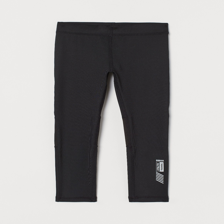

In [23]:
train_ds[0]['image'].resize((224,224))

In [24]:
train_ds[0]['text']

'solid black sports tights with elastication and a concealed drawstring at the waist ventilating mesh sections at the back of the knees and reflective details'

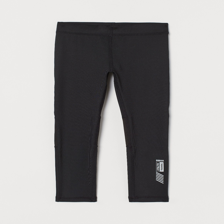

In [25]:
## print text and image of one ID
train_ds[0]['image'].resize((224,224))

In [26]:
train_ds[0]['text']

'solid black sports tights with elastication and a concealed drawstring at the waist ventilating mesh sections at the back of the knees and reflective details'

#### Decrease image size from (1166, 1750) to (224,224)

In [28]:
print(f"size of image: {train_ds[0]['image'].size}")

## REF: https://huggingface.co/docs/datasets/v2.0.0/en/image_process
# resize all images to (1024, 500) -- this is recommended image size here will will resize to (224, 224)
def transforms(examples):
    # examples["pixel_values"] = [image.convert("RGB").resize((224,224)) for image in examples["image"]]
    examples["image"] = [image.convert("RGB").resize((224,224)) for image in examples["image"]]
    return examples
train_ds = train_ds.map(transforms, batched=True)
test_ds = test_ds.map(transforms, batched=True)
valid_ds = valid_ds.map(transforms, batched=True)

size of image: (1166, 1750)


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

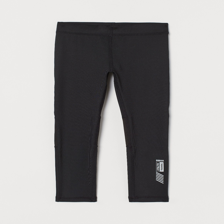

In [29]:
train_ds[0]['image']

### Create PyTorch Dataset
These lines are entirely copied from the original notebook

ref: https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb

In [30]:
## REF: https://github.com/huggingface/notebooks/blob/main/examples/image_captioning_blip.ipynb
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [38]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [39]:
# train_ds, test_ds, valid_ds
train_dataset = ImageCaptioningDataset(train_ds, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
print(type(train_dataset), type(train_dataloader.dataset))
print(train_dataset.dataset.shape, train_dataloader.dataset.dataset.shape)

<class '__main__.ImageCaptioningDataset'> <class '__main__.ImageCaptioningDataset'>
(50, 2) (50, 2)


In [40]:
# REF: https://stackoverflow.com/questions/73747731/runtimeerror-cuda-out-of-memory-how-can-i-set-max-split-size-mb
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

## REF: https://dev.to/shittu_olumide_/memory-management-using-pytorchcudaallocconf-5afh
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "caching_allocator"

### Train the model

In [41]:
# # Time each Epoch
# import time

import torch
torch.cuda.empty_cache()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device:{device}')
model.to(device)

model.train()
# losses = []
for epoch in range(40):
  # start_time = time.time()                   # starttimer before Epoch begins
  print("Epoch begin:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss
    # losses.append(loss.item())
    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
  # Epoch end
  # exec_time = time.time() - start_time
  # print("Execution time in mins: " + str(round(execution_time/60, 2)))  # print time taken

device:cuda
Epoch begin: 0
Loss: 12.705005645751953
Loss: 10.007216453552246
Loss: 9.828536987304688
Loss: 8.969148635864258
Loss: 8.713133811950684
Loss: 8.413381576538086
Loss: 8.142592430114746
Epoch begin: 1
Loss: 7.984982013702393
Loss: 7.848836421966553
Loss: 7.725448131561279
Loss: 7.584613800048828
Loss: 7.414816379547119
Loss: 7.367102146148682
Loss: 7.246659278869629
Epoch begin: 2
Loss: 7.037817478179932
Loss: 6.957139492034912
Loss: 6.855281352996826
Loss: 6.720898151397705
Loss: 6.589847564697266
Loss: 6.507114410400391
Loss: 6.360198497772217
Epoch begin: 3
Loss: 6.209792613983154
Loss: 6.096590518951416
Loss: 5.9700398445129395
Loss: 5.866469860076904
Loss: 5.692907810211182
Loss: 5.6047844886779785
Loss: 5.431919574737549
Epoch begin: 4
Loss: 5.319929599761963
Loss: 5.186934947967529
Loss: 5.11234188079834
Loss: 4.934553146362305
Loss: 4.813923358917236
Loss: 4.686061382293701
Loss: 4.546724319458008
Epoch begin: 5
Loss: 4.401360034942627
Loss: 4.278845310211182
Loss: 4

<h3>Inference</h3>
Let's check against validation and test sets

In [42]:
prompt = "This is a picture of"

def inference_one():
  # load image
  from random import randrange
  sample = randrange(len(test_ds))
  image = test_ds[sample]['image']

  # prepare image for the model
  # to(device,torch.float16)
  inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  print(f'Generated caption: {generated_caption}')
  print(f"Ground caption: {test_ds[sample]['text']}")

  # show image
  return image


Generated caption: solid white blouse in a soft cotton weave with a v - neck and long puff sleeves with narrow elastication at the back and a v - neckline at the cuffs and hem unlined
Ground caption: solid white straight-cut blouse in a crepe weave with a v-neck and 34-length sleeves with slits and ties at the cuffs


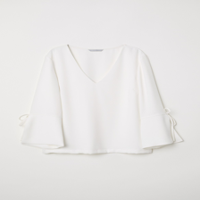

In [43]:
img = inference_one()
img.resize((200,200))

### Plot images





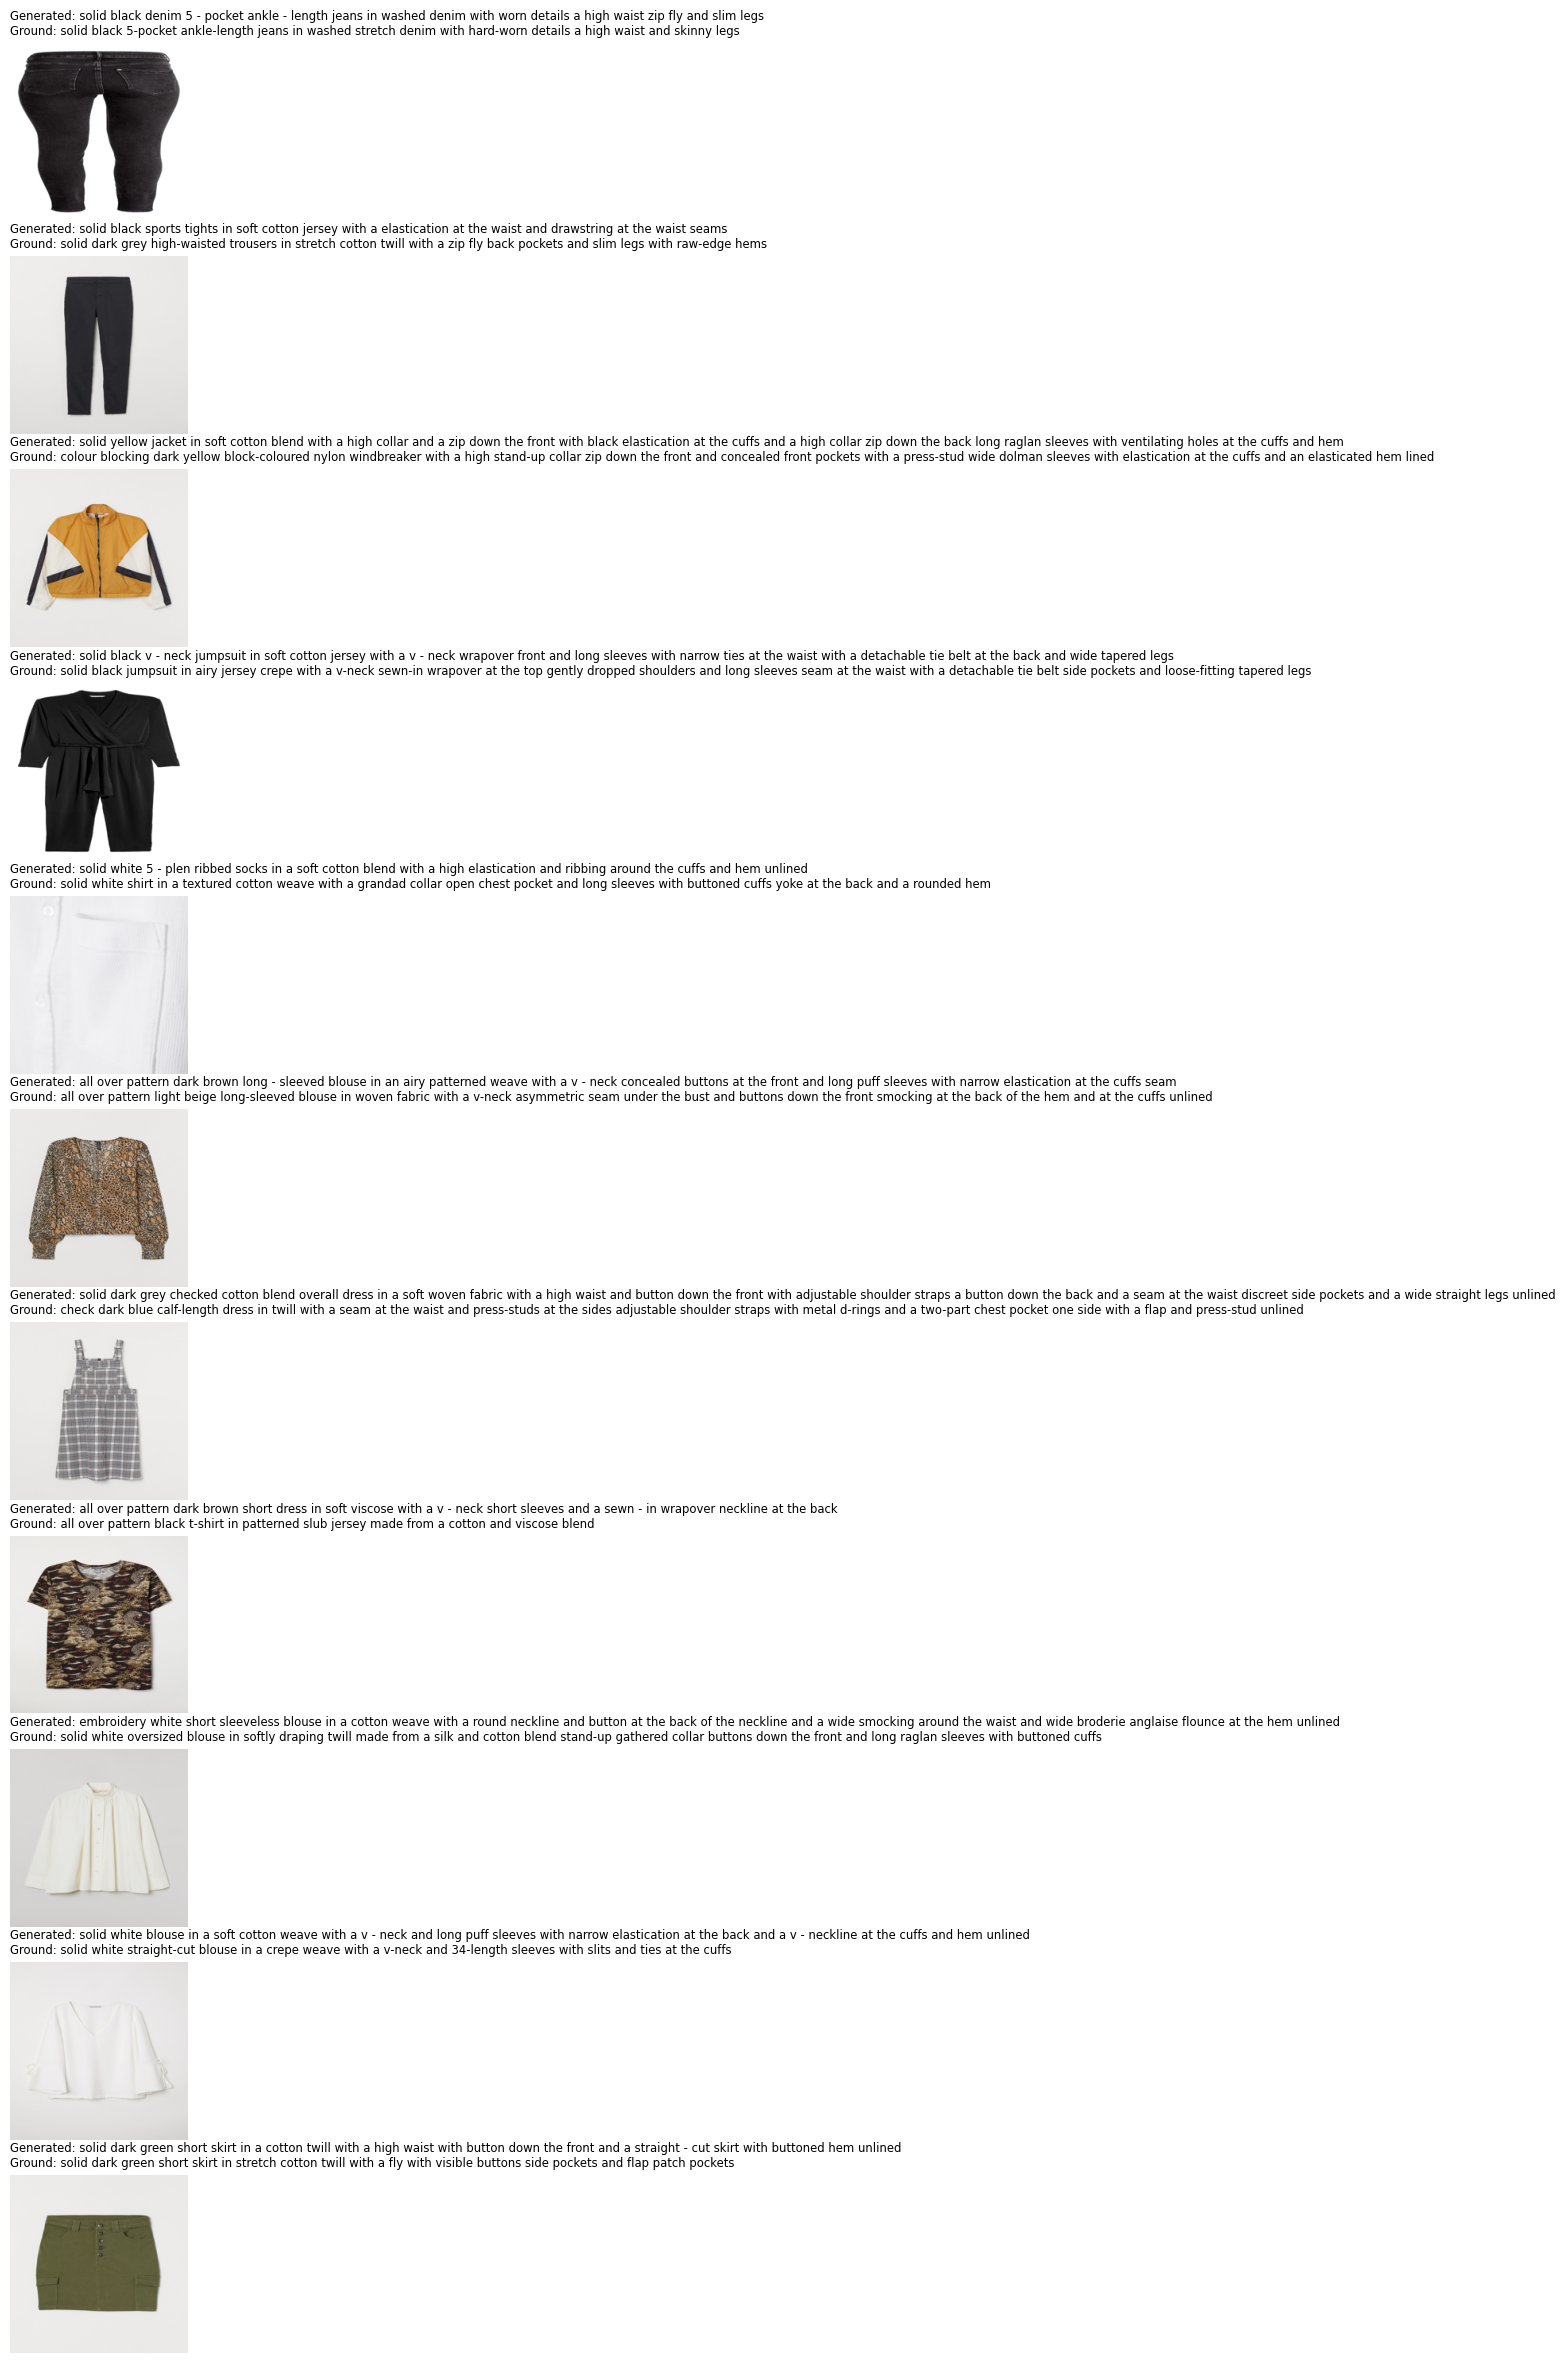

In [44]:
prompt = "This is a picture of"
generated_titles = []
params = {'legend.fontsize': 'small',
          'figure.figsize': (30, 30),
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
plt.rcParams.update(params)

# fig = plt.figure(figsize=(40, 40))
fig = plt.figure()
# plt.subplots_adjust(left=0, bottom=0, right=1, top=2, wspace=0, hspace=0)

# prepare image for the model
num_rows = test_ds.shape[0]    # 2
num_cols = 1                   # 3
for i, example in enumerate(test_ds):
  image = example["image"]
  # print(f"Ground: {example['text']}")
  # to(device,torch.float16)
  inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(num_rows, num_cols, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated: {generated_caption}\nGround: {example['text']}", loc='left')
  generated_titles.append(generated_caption)

### Evaluation Metrics

In [45]:
test_ds_df = test_ds.to_pandas()
test_ds_df.columns = ['image','reference']
test_ds_df['predicted'] = generated_titles
test_ds_df.head()
predictions = test_ds_df['predicted']
references = test_ds_df['reference']

#### ROGUE Score

In [46]:
# Load the ROUGE metric
import evaluate
rouge = evaluate.load('rouge')
rouge_results = rouge.compute(predictions=predictions, references=references)
# print(rouge_results)
rouge_results = pd.DataFrame.from_dict(rouge_results, orient='index')
rouge_results.columns=['ROGUE Score']
rouge_results

,ROGUE Score
rouge1,0.497704
rouge2,0.264534
rougeL,0.464498
rougeLsum,0.458109


#### BLUE Score
https://huggingface.co/spaces/evaluate-metric/bleu

In [47]:
bleu = evaluate.load("bleu")
blue_results = bleu.compute(predictions=predictions, references=references)
# print(blue_results)
blue_results = pd.DataFrame.from_dict(blue_results, orient='index').T
blue_results[['precision1', 'precision2', 'precision3', 'precision4']] = pd.DataFrame(blue_results.precisions.tolist(), index=blue_results.index)
blue_results.drop(labels=['precisions'], axis=1, inplace=True)
blue_results.index=['BLUE Score']
blue_results.T

,BLUE Score
bleu,0.149191
brevity_penalty,1.0
length_ratio,1.171617
translation_length,355
reference_length,303
precision1,0.447887
precision2,0.218023
precision3,0.102102
precision4,0.049689


#### BERT Score
https://huggingface.co/spaces/evaluate-metric/bertscore

In [48]:
from evaluate import load
bertscore = load("bertscore")
bert_results = bertscore.compute(predictions=predictions, references=references, lang="en")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
## create DataFrame
bert_results_df = pd.DataFrame()
bert_results_df['precision'] = bert_results['precision']
bert_results_df['recall'] = bert_results['recall']
bert_results_df['f1'] = bert_results['f1']
bert_results_df

,precision,recall,f1
0,0.947720,0.955198,0.951444
1,0.860002,0.866463,0.863220
2,0.901559,0.870838,0.885933
3,0.933865,0.912280,0.922946
4,0.848349,0.858957,0.853620
5,0.894083,0.893280,0.893681
6,0.880551,0.874384,0.877457
7,0.837851,0.877038,0.856997
8,0.837293,0.857863,0.847453
9,0.885616,0.913845,0.899509
